In [3]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc_context
import matplotlib.patheffects as path_effects
from matplotlib import colors as mcolors
import sunpy
import sunpy.map
from sunpy.coordinates import (propagate_with_solar_surface,
                               HeliographicStonyhurst)
import astropy
from astropy.coordinates import SkyCoord
import astropy.units as u
import astropy.constants as const
from astropy.io import fits
from astropy.time import Time
from astropy.convolution import convolve, Gaussian2DKernel
from sunkit_magex import pfss as pfsspy
import pfsspy.utils
import pfsspy.tracing as tracing


import cmcrameri.cm as cmcm
from matplotlib.ticker import (AutoLocator, AutoMinorLocator, 
    FixedLocator, FixedFormatter, LogLocator, StrMethodFormatter)
from astropy.visualization import (AsinhStretch, LinearStretch,
        LogStretch, ImageNormalize)
from regions import (CircleSkyRegion, Regions, EllipseSkyRegion)
from fancy_colorbar import plot_colorbar

from sunkit_pyvista import SunpyPlotter

import sys
sys.path.append("/home/yjzhu/scripts/Null_Finder/")
from null_finder import find_nulls

In [4]:
# based on mag2pfsspy https://github.com/STBadman/magnetograms2pfsspy/blob/master/mag2pfsspy.py#L12
# written by Samuel Badman, but updated to fit pfsspy 1.2.0
# pfsspy is archived at this moment, but I still use it when the succeeding sunkit-magex is under development
# def extract_br(m):
# 	br = m.data
# 	br = br - np.nanmean(br)
# 	# GONG maps have their LH edge at -180deg, so roll to get it at 0deg
# 	br = np.roll(br, int((m.meta['CRVAL1'] + 180)/np.abs(m.meta['cdelt1'])), axis=1)
# 	br = np.nan_to_num(br)
# 	return br*1e5 # Gauss to nT

def hmi2pfsspy(filepath,rss=2.5,nr=60,ret_magnetogram=False,resample=None, map_type='daily',
			   ext=0): 
	if map_type == 'daily':
		hmi_fits_data = fits.getdata(filepath,ext=ext)
		hmi_fits_header = fits.getheader(filepath,ext=ext)
		hmi_fits_header['CUNIT2'] = 'Sine Latitude'
		# for card in ['HGLN_OBS','CRDER1','CRDER2','CSYSER1','CSYSER2'] :
		# 	hmi_fits_header[card] = 0

		hmi_fits_header['T_OBS'] = hmi_fits_header['T_OBS'][:-8]+"_TAI"

		hmi_fits_data = np.nan_to_num(hmi_fits_data, nan=0.0)
		# since the cdelt1 is flipped, one should also update the crval1 either through sunpy.L0 (like sam) or manually from FITS header
		# hmi_fits_header['CRVAL1'] = 120 + sun.L0(time=hmi_fits_header['T_OBS']).to_value(u.deg)
		hmi_fits_header['CRVAL1'] = (2262*360*u.deg - \
		(hmi_fits_header["CRVAL1"] + hmi_fits_header["NAXIS1"]*hmi_fits_header["CDELT1"])*u.deg).to_value(u.deg)
		# print(hmi_fits_header['CRVAL1'])

		hmi_map = sunpy.map.sources.HMISynopticMap(hmi_fits_data,hmi_fits_header)
	elif map_type == 'cr':
		hmi_map = sunpy.map.Map(filepath)
		hmi_map = sunpy.map.Map(np.nan_to_num(hmi_map.data, nan=0.0), hmi_map.meta)
		
	if resample is not None: 
		hmi_map_size = hmi_map.data.shape
		x_superpixel = int(hmi_map_size[1]/resample[0].value)
		y_superpixel = int(hmi_map_size[0]/resample[1].value)
		x_std = x_superpixel
		y_std = y_superpixel

		kernel = Gaussian2DKernel(x_stddev=x_std, y_stddev=y_std)
		hmi_map_conv = convolve(hmi_map.data, kernel, boundary='extend')
		hmi_map_conv = sunpy.map.sources.HMISynopticMap(hmi_map_conv, hmi_fits_header)
		hmi_map = hmi_map_conv.superpixel([x_superpixel, y_superpixel]*u.pix, func=np.nanmean)
	
	# br_hmi = extract_br(hmi_map)
	if ret_magnetogram:
		return hmi_map
	pfss_input = pfsspy.Input(hmi_map, nr, rss,)

	pfss_output = pfsspy.pfss(pfss_input)
	return pfss_output

In [5]:
hmi_map = hmi2pfsspy("../../src/HMI/CR2263/hmi.Mrdailysynframe_720s.20221025_120000_TAI.data.fits",
                        resample=[720,360]*u.pix,nr=100, rss=2.5, ret_magnetogram=True)

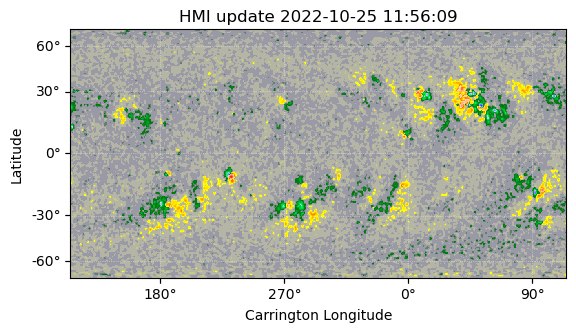

In [6]:
hmi_map.plot()

In [7]:
pfss_output = hmi2pfsspy("../../src/HMI/CR2263/hmi.Mrdailysynframe_720s.20221025_120000_TAI.data.fits",
                        resample=[360,180]*u.pix,nr=70, rss=2.5)

In [11]:
pfss_output_bphi = pfss_output.bg[:-1,:,:,0]
pfss_output_btheta =  pfss_output.bg[:-1,:,:,1]
pfss_output_br = pfss_output.bg[:-1,:,:,2]

In [12]:
pfss_output_bphi.shape

(360, 181, 71)

In [22]:
phi_coord = np.linspace(0,2*np.pi,361)[:360]
theta_coord = np.linspace(0,np.pi,181)
br_coord = np.linspace(1,2.5,71)

phi_grid, theta_grid, br_grid = np.meshgrid(phi_coord, theta_coord, br_coord, indexing="ij")

In [24]:
null_list = find_nulls(360, 181, 71, phi_coord,theta_coord,br_coord,
                        pfss_output_bphi,pfss_output_btheta,pfss_output_br,tolerance=None)

In [26]:
len(null_list)

160

In [6]:
def trace_flines(pfss_output, seed, max_steps='auto'):
    tracer = tracing.FortranTracer(max_steps=max_steps)
    with propagate_with_solar_surface():
        flines = tracer.trace(seed, pfss_output)

    return flines

In [7]:
lat = np.linspace(0, 30, 20, endpoint=False)
# Create 32 points spaced between long={0, 360} degrees
lon = np.linspace(130,180,20, endpoint=False)
# Make a 2D grid from these 1D points
lat, lon = np.meshgrid(lat, lon, indexing="ij")
lat, lon = lat.ravel() * u.deg, lon.ravel() * u.deg

seeds = SkyCoord(lon, lat, hmi_map.meta['rsun_ref']*u.m, frame=hmi_map.coordinate_frame)
tracer = tracing.FortranTracer()
field_lines = tracer.trace(seeds, pfss_output)

/home/yjzhu/anaconda3/envs/sunpy/lib/python3.12/site-packages/pfsspy/output.py:95: UserWarning: Could not parse unit string "Mx/cm^2" as a valid FITS unit.
See https://fits.gsfc.nasa.gov/fits_standard.html for the FITS unit standards.
  warnings.warn(f'Could not parse unit string "{unit_str}" as a valid FITS unit.\n'
/home/yjzhu/anaconda3/envs/sunpy/lib/python3.12/site-packages/pfsspy/tracing.py:180: UserWarning: At least one field line ran out of steps during tracing.
You should probably increase max_steps (currently set to auto) and try again.
  warnings.warn(


In [8]:
eis_195_velmap_shift_1025 = sunpy.map.Map("../../src/EIS/DHB_007_v2/20221025T2011/sunpymaps/eis_195_velmap_shift.fits")
eis_195_velmap_shift_1020 = sunpy.map.Map("../../src/EIS/DHB_007_v2/20221020T2343/sunpymaps/eis_195_velmap_shift.fits")

In [9]:
eis_east_region = Regions.read("../../sav/regions/eis_1025_east_pixel.reg")[0].to_sky(eis_195_velmap_shift_1025.wcs)
eis_west_region = Regions.read("../../sav/regions/eis_1020_west_pixel.reg")[0].to_sky(eis_195_velmap_shift_1020.wcs)

For frame 'heliographic_stonyhurst' the following metadata is missing: hglt_obs,dsun_obs,hgln_obs
For frame 'heliographic_carrington' the following metadata is missing: crlt_obs,crln_obs,dsun_obs
 [sunpy.map.mapbase]
For frame 'heliographic_stonyhurst' the following metadata is missing: hglt_obs,dsun_obs,hgln_obs
For frame 'heliographic_carrington' the following metadata is missing: crlt_obs,crln_obs,dsun_obs
 [sunpy.map.mapbase]


In [10]:
with propagate_with_solar_surface(rotation_model='rigid'):
    seeds_east_index = np.where(eis_east_region.contains(seeds, eis_195_velmap_shift_1025.wcs))
    seeds_west_index = np.where(eis_west_region.contains(seeds, eis_195_velmap_shift_1020.wcs))

field_lines_east = tracer.trace(seeds[seeds_east_index], pfss_output)
field_lines_west = tracer.trace(seeds[seeds_west_index], pfss_output)

seeds_rest = np.delete(seeds, np.concatenate([seeds_east_index[0], seeds_west_index[0]]))
field_lines_rest = tracer.trace(seeds_rest, pfss_output)

/home/yjzhu/anaconda3/envs/sunpy/lib/python3.12/site-packages/pfsspy/tracing.py:180: UserWarning: At least one field line ran out of steps during tracing.
You should probably increase max_steps (currently set to auto) and try again.
  warnings.warn(


In [11]:
def get_loop_length(line):
    c = line.coords.cartesian.xyz
    s = np.append(0., np.linalg.norm(np.diff(c.value, axis=1), axis=0).cumsum()) * c.unit
    return np.diff(s).sum()

In [12]:
def my_fline_color_func(field_line):
    # norm = mcolors.LogNorm(vmin=1, vmax=1000)
    # cmap = plt.get_cmap("viridis")
    # return cmap(norm(np.abs(field_line.expansion_factor)))
    if get_loop_length(field_line) > 100 * u.Mm:
        if field_line.is_open:
            return (88/255.,178/255.,220/255.,1)
        else:
            return (232/255.,48/255.,21/255.,1)
    else:
        return (0., 0., 0., 0.)

In [13]:
def plain_fline_color_func(field_line):
    if get_loop_length(field_line) > 100 * u.Mm:
        if field_line.is_open:
            return (145/255,180/255,147/255,1)
        else:
            return (250/255,214/255,137/255,1)
    else:
        return (0,0,0,0)

In [14]:
aia_193_map = sunpy.map.Map("../../src/AIA/20221025/193/lvl15/aia.lev1_euv_12s.2022-10-25T192003Z.193.image.fits")
aia_193_map = aia_193_map.resample([1024,1024]*u.pix)

In [15]:
try:
    del plotter
except:
    pass

plotter = SunpyPlotter(notebook=True, window_size=[1600, 800])
fieldline_kwargs = dict(render_lines_as_tubes=True,line_width=3,)
# Plot a map
hmi_map.plot_settings['norm'] = ImageNormalize(vmin=-1500, vmax=1500)
plotter.plot_map(hmi_map, cmap="hmimag",)
# plotter.plot_map(aia_193_map, clip_interval=[1,99]*u.percent, assume_spherical_screen=False)

# Add an arrow to show the solar rotation axis
plotter.plot_field_lines(field_lines, color_func=my_fline_color_func, **fieldline_kwargs)
# plotter.plot_field_lines(field_lines_east,color_func=my_fline_color_func, **fieldline_kwargs)
# plotter.plot_field_lines(field_lines_west,color_func=my_fline_color_func, **fieldline_kwargs)
# plotter.plot_field_lines(field_lines_rest,color_func=plain_fline_color_func, **fieldline_kwargs)

plotter.plot_solar_axis()
# camera_coord = SkyCoord(
#     -20 * u.deg,
#     0 * u.deg,
#     5 * const.R_sun,
#     frame=HeliographicStonyhurst,
#     obstime=Time("2022-10-25T12:00"),
# )

# # plotter.camera.zoom('tight')
# plotter.set_camera_coordinate(camera_coord)
plotter.disable_shadows()

# def track_camera_loc():
#     print(f'camera position: {plotter.camera.position}')
#     print(f'camera az,rol,elev: {plotter.camera.azimuth},{plotter.camera.roll},\
#             {plotter.camera.elevation}')
#     print(f'camera view angle, focal point: {plotter.camera.view_angle,plotter.camera.focal_point}')

# plotter.add_key_event('t',track_camera_loc)

# side view 1
# camera position: (3.648652361040791, -1.8282042713826914, -0.4883232610738903)
# camera az,rol,elev: 0.0,-139.9655979948479,            0.0
# camera view angle, focal point: (30.0, (0.4097475860508218, -1.1841258832474448, 0.46780273177273557))

# side view 2
# camera position: (0.48218554725537255, -1.3166968139228004, -0.824578522629973)
# camera az,rol,elev: 0.0,-168.38537491277543,            0.0
# camera view angle, focal point: (30.0, (0.7645185924105996, -0.93621981476814, 0.5839597521464222))

# plotter.camera.position = (3.648652361040791, -1.8282042713826914, -0.4883232610738903)
# plotter.camera.azimuth = 0.0
# plotter.camera.roll = -139.9655979948479
# plotter.camera.elevation = 0.0

# plotter.camera.view_angle = 30.0
# plotter.camera.focal_point = (0.4097475860508218, -1.1841258832474448, 0.46780273177273557)

plotter.camera.position = (0.48218554725537255, -1.3166968139228004, -0.824578522629973)
plotter.camera.azimuth = 0.0
plotter.camera.roll = -168.38537491277543
plotter.camera.elevation = 0.0

plotter.camera.view_angle = 30.0
plotter.camera.focal_point = (0.7645185924105996, -0.93621981476814, 0.5839597521464222)

plotter.show()

2024-10-10 15:15:48.456 (  41.807s) [        732E4740]   vtkTextureObject.cxx:1025   ERR| vtkTextureObject (0x5654dff99420): Attempt to use a texture buffer exceeding your hardware's limits. This can happen when trying to color by cell data with a large dataset. Hardware limit is 65536 values while 517680 was requested.
ERROR:root:Attempt to use a texture buffer exceeding your hardware's limits. This can happen when trying to color by cell data with a large dataset. Hardware limit is 65536 values while 517680 was requested.


Widget(value='<iframe src="http://localhost:32901/index.html?ui=P_0x7f1fb8b44ef0_0&reconnect=auto" class="pyvi…

In [16]:
# plotter.save_graphic("../../figs/test_figs/20221025_flines.pdf")
plotter.screenshot("../../figs/test_figs/20221025_flines.png",)
plotter.export_vtksz("../../figs/test_figs/20221025_flines.vtksz")

'../../figs/test_figs/20221025_flines.vtksz'

In [17]:
# !jupyter nbconvert --to script hmi_pfss_pyvista_test.ipynb